In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import MiniBatchKMeans

sns.set_theme(style="darkgrid")
from multiprocessing import cpu_count

max_cores = cpu_count()
print("Max cores available: ", max_cores)


Max cores available:  8


In [2]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.sin(dLon / 2) * math.sin(
        dLon / 2
    ) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


def heading(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dLon = lon2 - lon1

    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(
        dLon
    )

    brng = math.atan2(y, x)
    return (math.degrees(brng) + 360) % 360


def destination_latlong(lat, lon, heading, distance):
    R = 6371.01  # Earth's radius in km
    bearing = math.radians(heading)
    # Convert latitude and longitude to radians
    lat_rad, lon_rad = map(math.radians, [lat, lon])
    # Calculate the new latitude
    lat_new = math.asin(
        math.sin(lat_rad) * math.cos(distance / R)
        + math.cos(lat_rad) * math.sin(distance / R) * math.cos(bearing)
    )
    # Calculate the new longitude
    lon_new = lon_rad + math.atan2(
        math.sin(bearing) * math.sin(distance / R) * math.cos(lat_rad),
        math.cos(distance / R) - math.sin(lat_rad) * math.sin(lat_new),
    )
    # Convert latitude and longitude back to degrees
    lat_new, lon_new = map(math.degrees, [lat_new, lon_new])

    return lat_new, lon_new


def angle_distance(angle1, angle2):
    """
    Calculate the smallest absolute difference between two angles in degrees.
    """
    return abs(((angle2 - angle1) + 180) % 360 - 180)


def cartesian_product(series):
    # Create two dataframes with the same series
    df1 = pd.DataFrame({"x": series})
    df2 = pd.DataFrame({"y": series})

    # Add a dummy column in both dataframes to use it as a join key
    df1["key"] = 0
    df2["key"] = 0

    # Merge the two dataframes based on the dummy column
    result = pd.merge(df1, df2, on="key", how="outer").drop("key", axis=1)

    # Remove rows where x and y values are equal
    result = result.loc[result["x"] != result["y"]].reset_index(drop=True)

    return result


# Data Cleaning

In [3]:
tb_vulture = pd.read_csv(
    "data/Long-range adult movements of 3 vulture species (data from Spiegel et al. 2015).csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
)
tb_vulture = tb_vulture.sort_values(by=["individual-local-identifier", "timestamp"])
tb_vulture["day"] = (
    tb_vulture["timestamp"].dt.year * 10000
    + tb_vulture["timestamp"].dt.month * 100
    + tb_vulture["timestamp"].dt.day
).astype(str)
tb_vulture["individual-local-identifier"] = tb_vulture[
    "individual-local-identifier"
].astype("category")
tb_vulture["time"] = tb_vulture["timestamp"].dt.time
tb_vulture["timestamp-l1"] = tb_vulture.groupby(["individual-local-identifier", "day"])[
    "timestamp"
].shift()
tb_vulture["timestep"] = (tb_vulture["timestamp"] - tb_vulture["timestamp-l1"]) / np.timedelta64(1, "m")  # type: ignore
tb_vulture["days_since_start"] = (tb_vulture["timestamp"] - tb_vulture.groupby("individual-local-identifier")["timestamp"].transform(min)) / pd.Timedelta("1 day")  # type: ignore


/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_2227/2786601226.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tb_vulture = pd.read_csv(


Evaluating each day's starting and ending observation times (according to the reasearchers collecting the data, observations only happened during the day, between sunrise and sunset):

In [5]:
tb_day = (
    tb_vulture.groupby(["individual-local-identifier", "day"], observed=True)
    .agg(
        start_time=("timestamp", "min"),
        end_time=("timestamp", "max"),
        num_obs=("timestamp", "count"),
        mean_timestep=("timestep", "mean"),
    )
    .reset_index()
)
tb_day["start_hsm"] = (
    tb_day["start_time"] - tb_day["start_time"].dt.normalize()
) / pd.Timedelta("1 hour")
tb_day["end_hsm"] = (
    tb_day["end_time"] - tb_day["end_time"].dt.normalize()
) / pd.Timedelta("1 hour")


(0.0, 100.0)

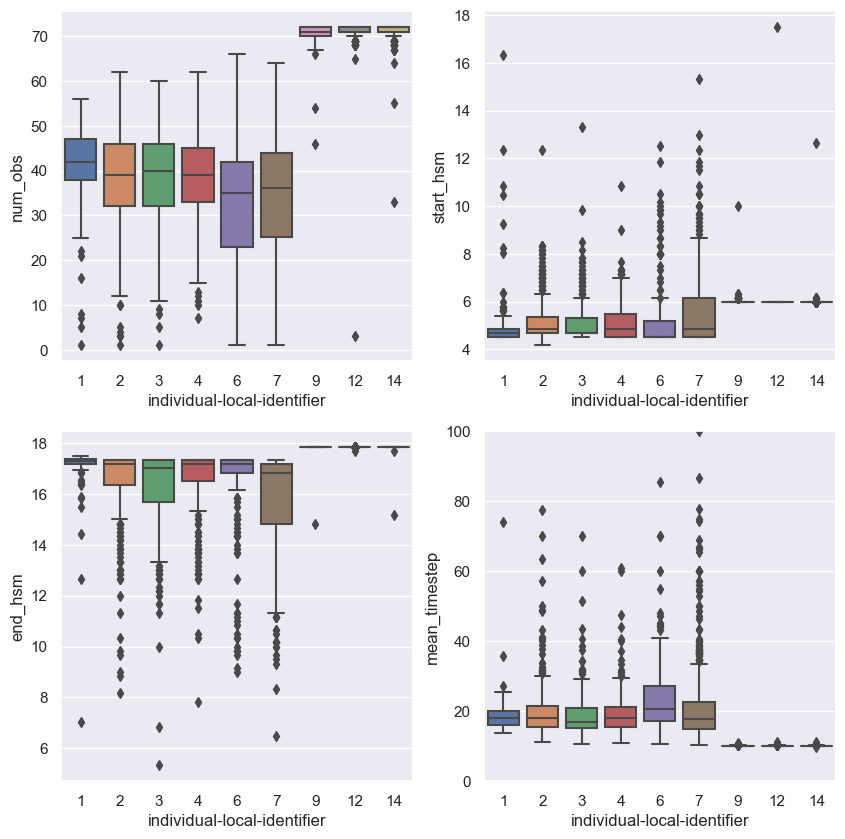

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(data=tb_day, x="individual-local-identifier", y="num_obs", ax=ax[0][0])
sns.boxplot(data=tb_day, x="individual-local-identifier", y="start_hsm", ax=ax[0][1])
sns.boxplot(data=tb_day, x="individual-local-identifier", y="end_hsm", ax=ax[1][0])
sns.boxplot(
    data=tb_day, x="individual-local-identifier", y="mean_timestep", ax=ax[1][1]
)
ax[1][1].set_ylim(0, 100)


In [7]:
pd.crosstab(
    tb_vulture["individual-local-identifier"],
    tb_vulture["individual-taxon-canonical-name"],
)


individual-taxon-canonical-name,Gyps africanus,Gyps fulvus,Torgos tracheliotus
individual-local-identifier,,,
1,0,4596,0
2,0,16310,0
3,0,13208,0
4,0,11903,0
6,0,6395,0
7,0,19294,0
9,26103,0,0
12,0,0,26960
14,27825,0,0


Text(0.5, 0.91, 'Vulture Flight Paths')

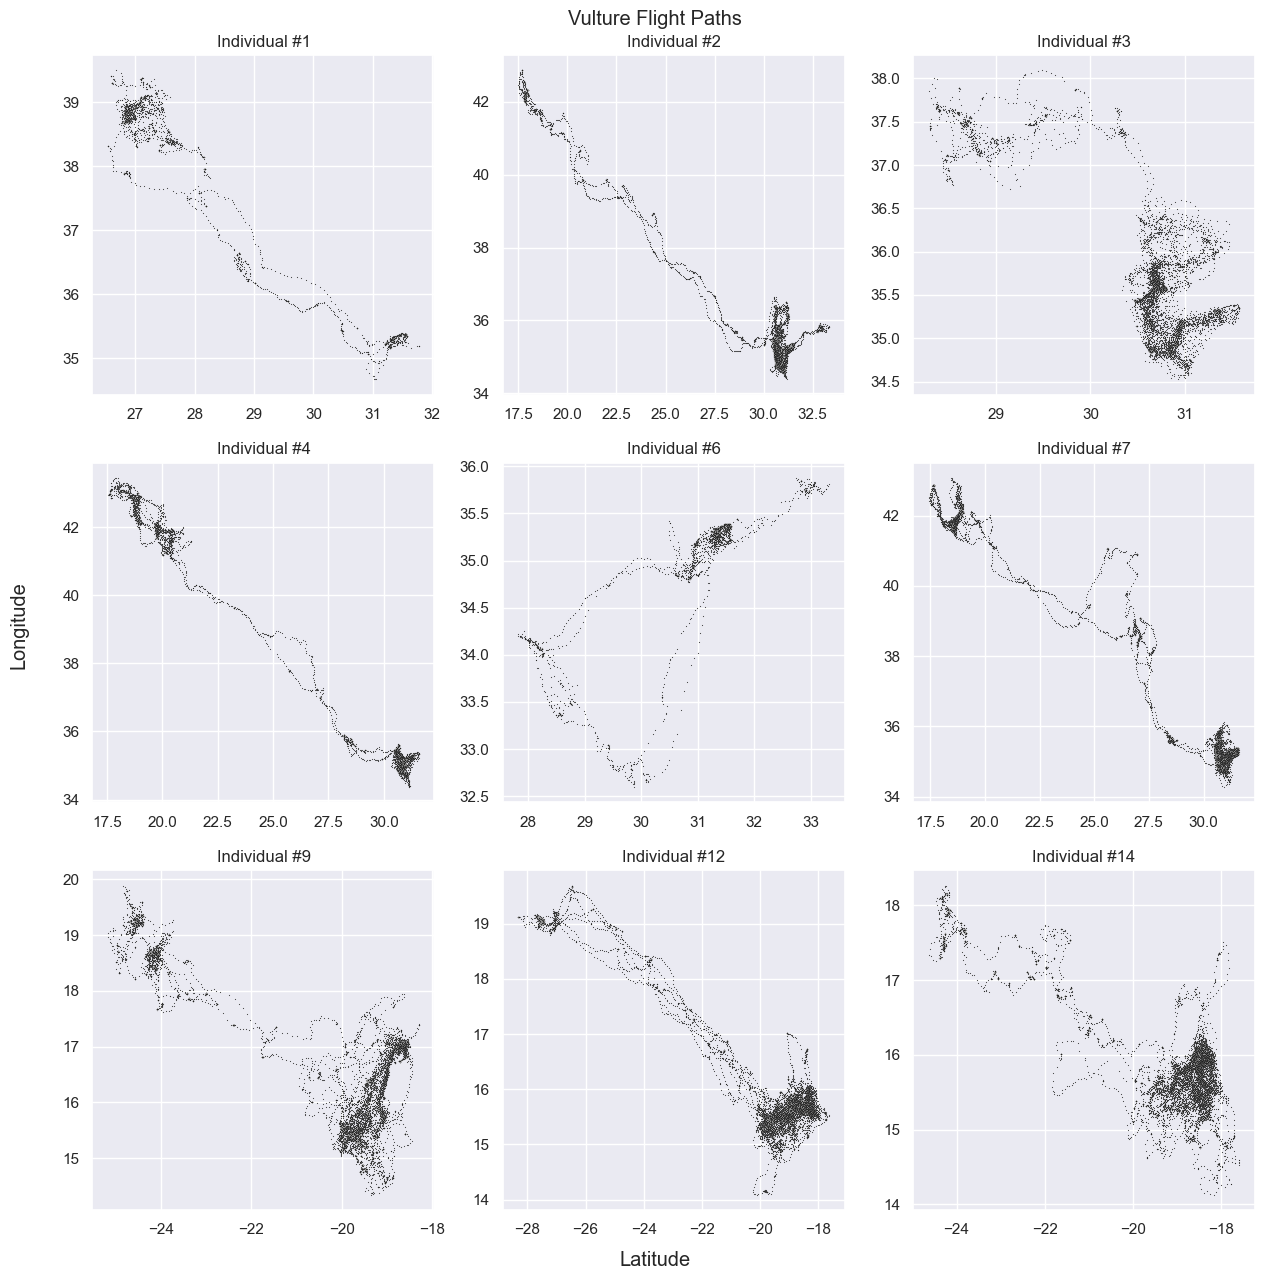

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(tb_vulture.groupby("individual-local-identifier")):
    sns.scatterplot(
        x="location-lat",
        y="location-long",
        data=group,
        ax=ax[i // 3, i % 3],
        color="black",
        s=0.7,
        alpha=0.8,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
fig.supxlabel("Latitude", y=0.07)
fig.supylabel("Longitude", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


The above graph shows the differences in data collection between individuals. Individuals 1 through 7 belong to the *Gyps fulvus* species, while individuals 9, 12 & 14 belong to the *Gyps africanus* and *Torgos Tracheliotus* species. We could separate the individuals and create specific models for each species. However, we can observe in the flight paths that the behavior across species is similar: all vultures exhibit Levy-like step distributions - alternating between local searchs and long flights.

Ideally, we will model this behaviour on a global level - leveraging information from each individual in a single model. This creates a host of problems regarding feature definition. This pattern is defined by an alteration between the long term and short-term self-correlation of the position vector: the local search most likely defined by very small long term correlation while the long flight is defined by the opposite. This pattern is much clearer on the atittude parameters (heading and velocity) rather than on the positional parameters.

First, let's investigate visually what long-term might mean for these specific individuals:

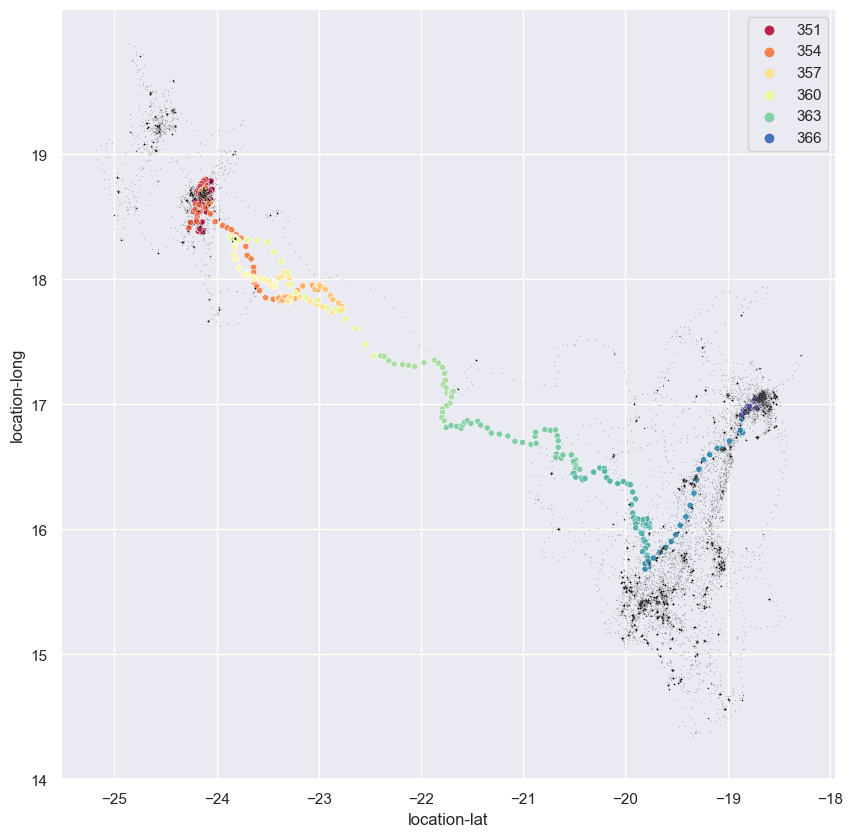

In [9]:
graph_data = tb_vulture[tb_vulture["individual-local-identifier"] == 9]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[graph_data["days_since_start"] > 350],
    hue="days_since_start",
    palette="Spectral",
    s=20,
    ax=ax,
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[graph_data["days_since_start"] <= 350],
    color="black",
    s=1,
    alpha=0.2,
    ax=ax,
)
ax.set_xticks(
    range(
        int(graph_data["location-lat"].min()),
        int(graph_data["location-lat"].max()) + 1,
        1,
    )
)
ax.set_yticks(
    range(
        int(graph_data["location-long"].min()),
        int(graph_data["location-long"].max()) + 1,
        1,
    )
)


Individual #9 presents a movement path between a SE & NW positions (separated by the 17.5 E meridian). The vulture starts in SE position, moves to NW then returns to the starting SE position - the graph above highlights the return path. The return path takes about 2 weeks to complete - but it's not a straight path. This simple analysis gives us a starting point for our smoothing parameters: the highest time-scale we will consider is 2 weeks.

Since our time-series is irregular (even within individuals) we cannot simply use the `.shift()` method: we will create a dictionary that maps the starting time to the closest destination time, e.g. if our observation was made at `2010-11-22 09:16:00` we will look for the closes observation precisely N days before.

In [10]:
tb_vulture = tb_vulture.sort_values(by=["timestamp"])


In [11]:
def lagged_position(dataframe, period):
    tolerance = period / 20
    temp = dataframe[
        ["individual-local-identifier", "location-long", "location-lat"]
    ].copy()
    temp[f"timestamp_l"] = dataframe["timestamp"]  # type: ignore
    temp["timestamp"] = dataframe["timestamp"] + pd.Timedelta(f"{period} days")  # type: ignore
    
    temp = temp.sort_values("timestamp")
    results = pd.merge_asof(
        dataframe.sort_values("timestamp"),
        temp,
        on="timestamp",
        tolerance=pd.Timedelta(f"{tolerance} days"),
        by="individual-local-identifier",
        suffixes=("", f"_{period}d"),
        allow_exact_matches=False,
    )
    
    results = results.sort_values(["individual-local-identifier", "timestamp"])
    results.reset_index(drop=True, inplace=True)
    results[f"heading_{period}d"] = results[
        [
            "location-long",
            "location-lat",
            f"location-long_{period}d",
            f"location-lat_{period}d",
        ]
    ].apply(lambda x: heading(*x), axis=1)
    
    results["distance"] = results[
        [
            "location-long",
            "location-lat",
            f"location-long_{period}d",
            f"location-lat_{period}d",
        ]
    ].apply(lambda x: distance(*x), axis=1)
    
    results[f"time_delta_{period}d"] = (results["timestamp"] - results[f"timestamp_l"])/pd.Timedelta("1 hour")
    results[f"speed_{period}d"] = results["distance"] / results[f"time_delta_{period}d"]
    
    results["heading_shift"] = results.groupby("individual-local-identifier")[
        f"heading_{period}d"
    ].shift()
    
    results[f"heading_{period}d_var"] = results[
        [f"heading_{period}d", "heading_shift"]
    ].apply(lambda x: angle_distance(*x), axis=1)
    
    results[f"mean_heading_{period}d_var"] = (
        results
        .groupby("individual-local-identifier")
        .rolling(f"{period/2}D", on="timestamp")[f"heading_{period}d_var"]
        .mean()
        .reset_index(drop=True)
    )
    results[f"log_mean_heading_{period}d_var"] = np.log(results[f"mean_heading_{period}d_var"])
    
    results = results.drop(
        columns=[f"location-lat_{period}d", f"location-long_{period}d", "heading_shift", "distance", "timestamp_l", f"time_delta_{period}d"]
    )

    return results


In [12]:
for i in [1, 2, 4, 8, 16]:
    tb_vulture = lagged_position(tb_vulture, i)  # type: ignore


<AxesSubplot: xlabel='location-lat', ylabel='location-long'>

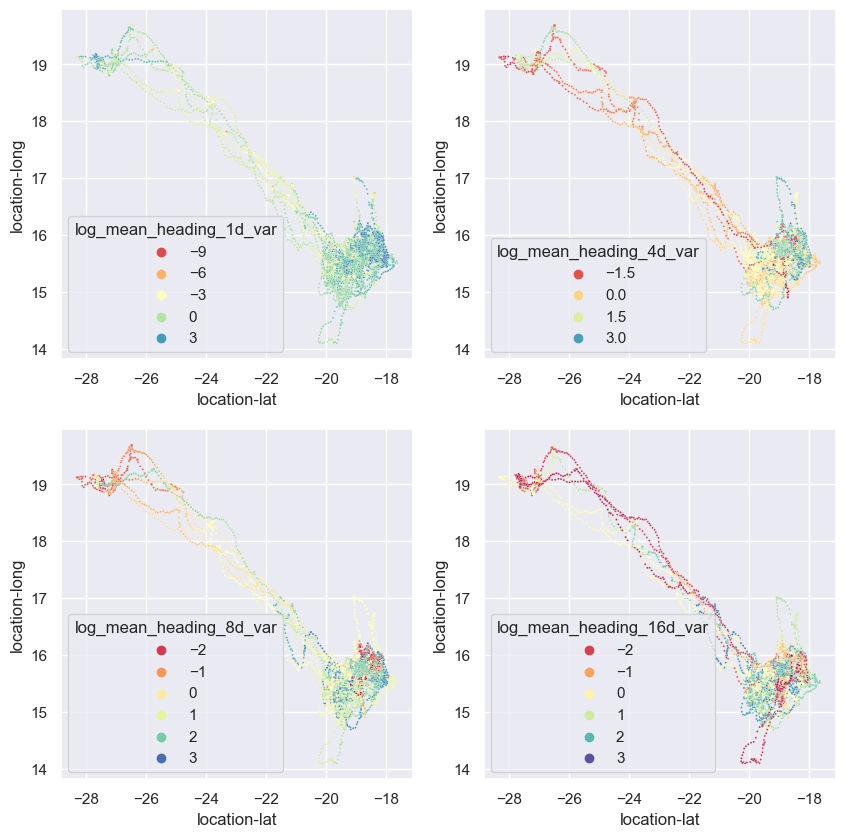

In [13]:
graph_data = tb_vulture[tb_vulture["individual-local-identifier"] == 12]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="log_mean_heading_1d_var",
    palette="Spectral",
    s=2,
    ax=ax[0][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="log_mean_heading_4d_var",
    palette="Spectral",
    s=2,
    ax=ax[0][1],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="log_mean_heading_8d_var",
    palette="Spectral",
    s=2,
    ax=ax[1][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="log_mean_heading_16d_var",
    palette="Spectral",
    s=2,
    ax=ax[1][1],
)


<AxesSubplot: xlabel='location-lat', ylabel='location-long'>

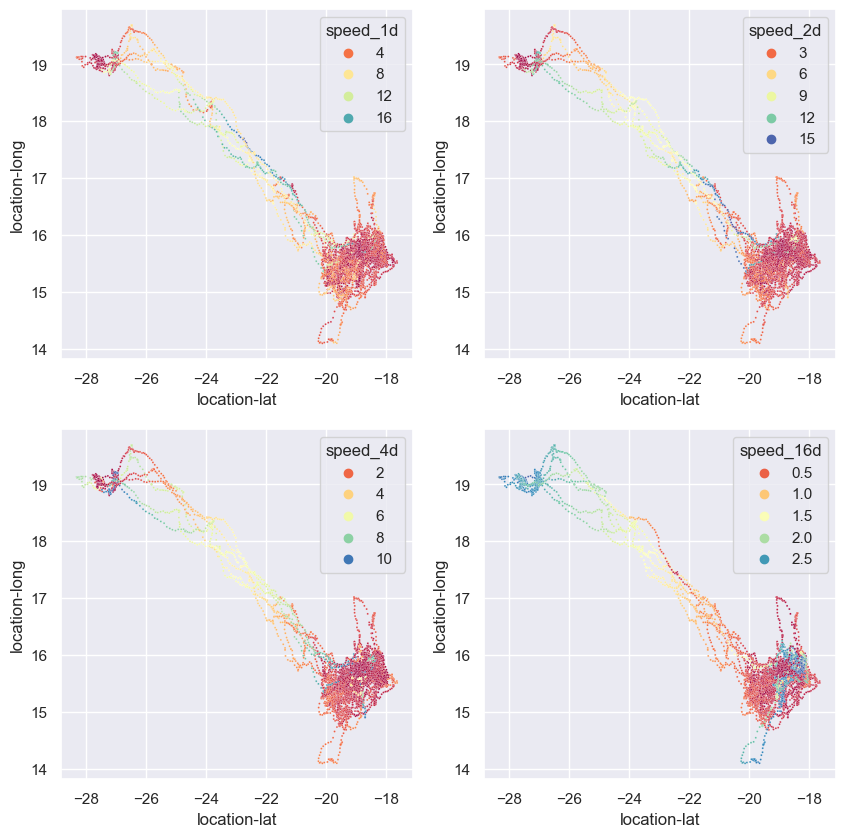

In [14]:
graph_data = tb_vulture[tb_vulture["individual-local-identifier"] == 12]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="speed_1d",
    palette="Spectral",
    s=2,
    ax=ax[0][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="speed_2d",
    palette="Spectral",
    s=2,
    ax=ax[0][1],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="speed_4d",
    palette="Spectral",
    s=2,
    ax=ax[1][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="speed_16d",
    palette="Spectral",
    s=2,
    ax=ax[1][1],
)


<AxesSubplot: xlabel='timestamp', ylabel='log_mean_heading_16d_var'>

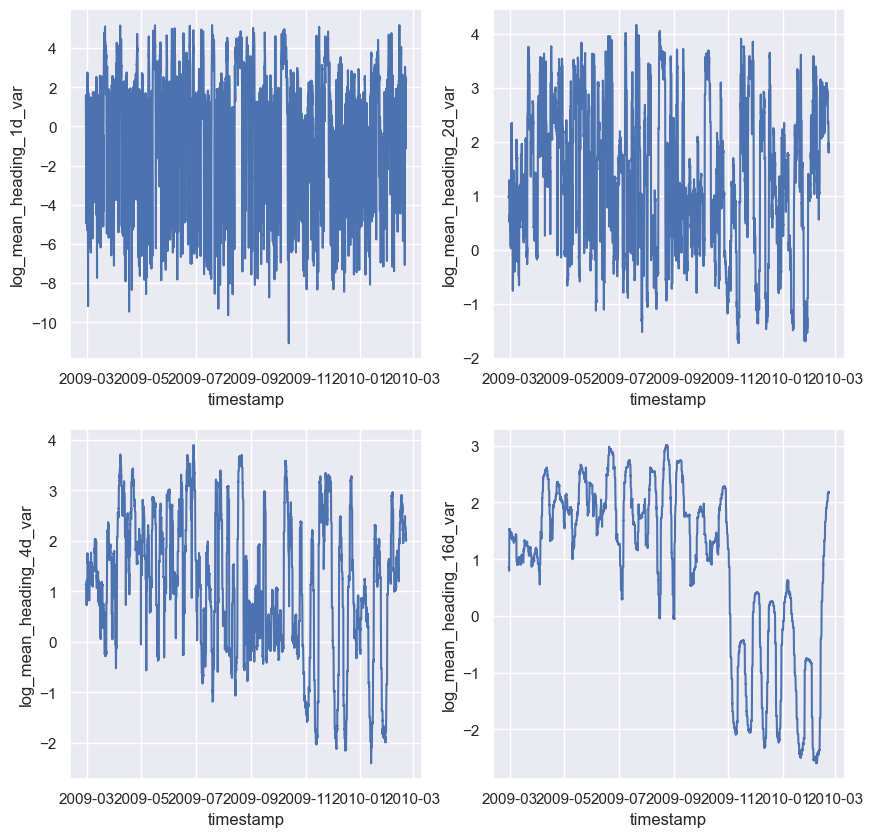

In [15]:
graph_data = tb_vulture[tb_vulture["individual-local-identifier"] == 12]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(
    x="timestamp",
    y="log_mean_heading_1d_var",
    data=graph_data[time_mask],
    ax=ax[0][0],
)
sns.lineplot(
    x="timestamp",
    y="log_mean_heading_2d_var",
    data=graph_data[time_mask],
    ax=ax[0][1],
)
sns.lineplot(
    x="timestamp",
    y="log_mean_heading_4d_var",
    data=graph_data[time_mask],
    ax=ax[1][0],
)
sns.lineplot(
    x="timestamp",
    y="log_mean_heading_16d_var",
    data=graph_data[time_mask],
    ax=ax[1][1],
)


<AxesSubplot: xlabel='timestamp', ylabel='speed_16d'>

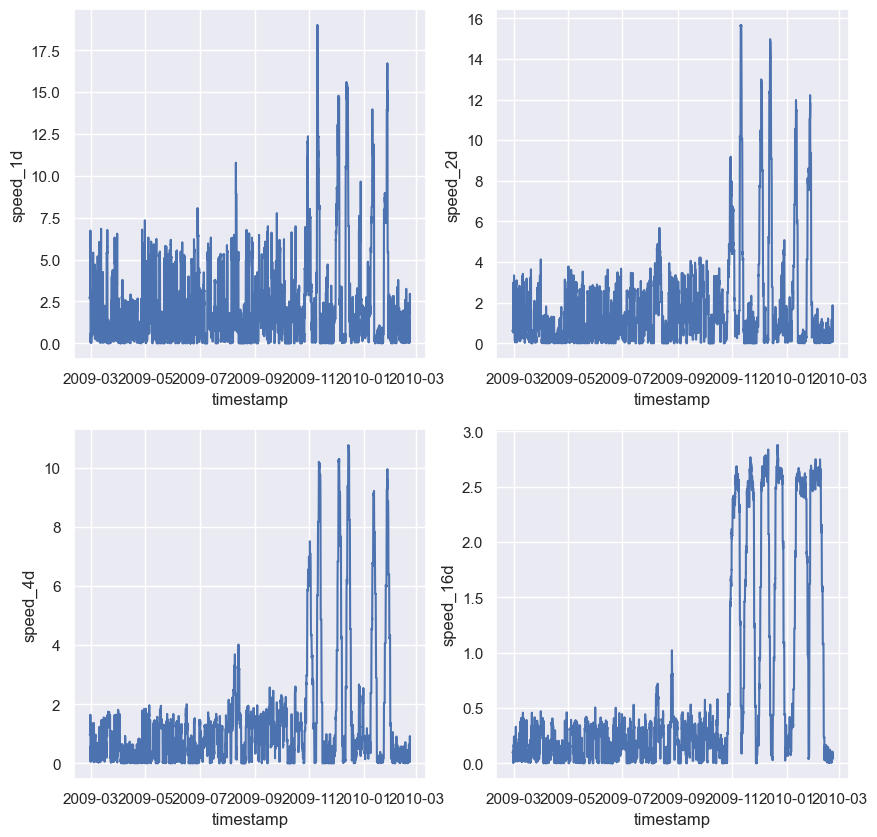

In [16]:
graph_data = tb_vulture[tb_vulture["individual-local-identifier"] == 12]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(
    x="timestamp",
    y="speed_1d",
    data=graph_data[time_mask],
    ax=ax[0][0],
)
sns.lineplot(
    x="timestamp",
    y="speed_2d",
    data=graph_data[time_mask],
    ax=ax[0][1],
)
sns.lineplot(
    x="timestamp",
    y="speed_4d",
    data=graph_data[time_mask],
    ax=ax[1][0],
)
sns.lineplot(
    x="timestamp",
    y="speed_16d",
    data=graph_data[time_mask],
    ax=ax[1][1],
)


In [17]:
tb_vulture

,event-id,visible,timestamp,location-long,location-lat,ground-speed,heading,sensor-type,individual-taxon-canonical-name,tag-local-identifier,...,heading_8d,speed_8d,heading_8d_var,mean_heading_8d_var,log_mean_heading_8d_var,heading_16d,speed_16d,heading_16d_var,mean_heading_16d_var,log_mean_heading_16d_var
0,382900959,True,2010-11-22 09:16:00,35.195745,31.777466,0.13,358.48,gps,Gyps fulvus,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,382900960,True,2010-11-22 09:36:01,35.195771,31.777446,0.20,353.89,gps,Gyps fulvus,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,382900961,True,2010-11-22 09:56:00,35.195758,31.777450,0.11,13.11,gps,Gyps fulvus,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,382900962,True,2010-11-22 10:16:00,35.195643,31.777432,0.31,352.58,gps,Gyps fulvus,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,382900963,True,2010-11-22 10:36:00,35.195831,31.777383,0.55,359.14,gps,Gyps fulvus,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152589,382999159,True,2010-03-09 14:20:00,15.984671,-18.561164,6.92,73.40,gps,Gyps africanus,659,...,290.592431,2.147511,0.013464,0.197248,-1.623294,289.257362,1.541126,0.025711,0.158850,-1.839794
152590,382999160,True,2010-03-09 14:30:00,15.941773,-18.611560,28.05,309.33,gps,Gyps africanus,659,...,291.376106,2.129228,0.783675,0.200024,-1.609318,289.831711,1.532329,0.574349,0.159591,-1.835141
152591,382999161,True,2010-03-09 14:40:00,15.971702,-18.570215,7.62,90.44,gps,Gyps africanus,659,...,290.652373,2.155733,0.723733,0.201875,-1.600109,289.395787,1.539595,0.435924,0.158578,-1.841512
152592,382999162,True,2010-03-09 14:50:00,15.991835,-18.559987,8.38,101.58,gps,Gyps africanus,659,...,290.862211,2.158926,0.209838,0.203307,-1.593040,289.158708,1.540364,0.237079,0.157900,-1.845795


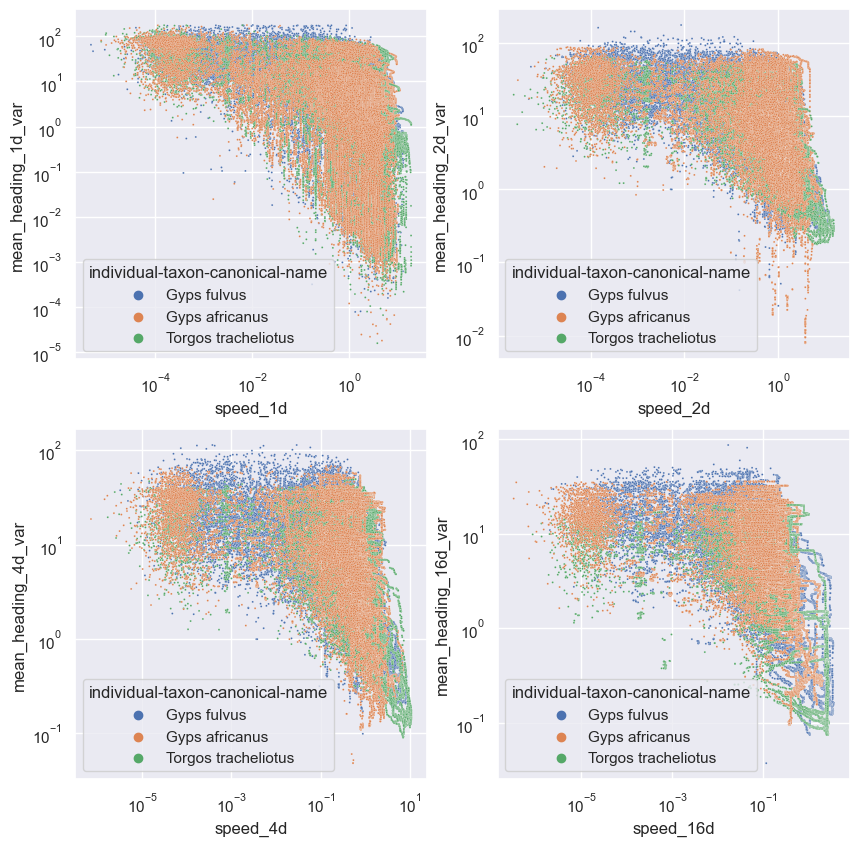

In [18]:
graph_data = tb_vulture #[tb_vulture["individual-local-identifier"] == 12]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(
    x="speed_1d",
    y="mean_heading_1d_var",
    data=graph_data[time_mask],
    hue="individual-taxon-canonical-name",
    s=2,
    ax=ax[0][0],
)
sns.scatterplot(
    x="speed_2d",
    y="mean_heading_2d_var",
    data=graph_data[time_mask],
    hue="individual-taxon-canonical-name",
    s=2,
    ax=ax[0][1],
)
sns.scatterplot(
    x="speed_4d",
    y="mean_heading_4d_var",
    data=graph_data[time_mask],
    hue="individual-taxon-canonical-name",
    s=2,
    ax=ax[1][0],
)
sns.scatterplot(
    x="speed_16d",
    y="mean_heading_16d_var",
    data=graph_data[time_mask],
    hue="individual-taxon-canonical-name",
    s=2,
    ax=ax[1][1],
)
ax[0][0].set_xscale("log")
ax[1][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[1][1].set_xscale("log")
ax[0][0].set_yscale("log")
ax[1][0].set_yscale("log")
ax[0][1].set_yscale("log")
ax[1][1].set_yscale("log")


In [19]:
model_vars = ['ground-speed', 'heading'] + [f"speed_{i}d" for i in [1, 2, 4, 8, 16]] + [f"mean_heading_{i}d_var" for i in [1, 2, 4, 8, 16]]
tb_model = tb_vulture.dropna(subset=model_vars).copy()
X = tb_model[model_vars].copy()

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
power = PowerTransformer()
pca = PCA(n_components=2)
pca_pipeline = Pipeline([("scaler", scaler), ("power", power), ("pca", pca)])
pca_pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('pca', PCA(n_components=2))])

In [21]:
tb_model[["PC1", "PC2"]] = pca_pipeline.transform(X)

In [22]:
import hdbscan

In [23]:
scaler = StandardScaler()
power = PowerTransformer()
hdb = hdbscan.HDBSCAN(min_cluster_size=50)
hdb_pipeline = Pipeline([("scaler", scaler), ("power", power), ("hdb", hdb)])
tb_model["cluster"] = hdb_pipeline.fit_predict(X)
tb_model["cluster"] = tb_model["cluster"].astype(str)

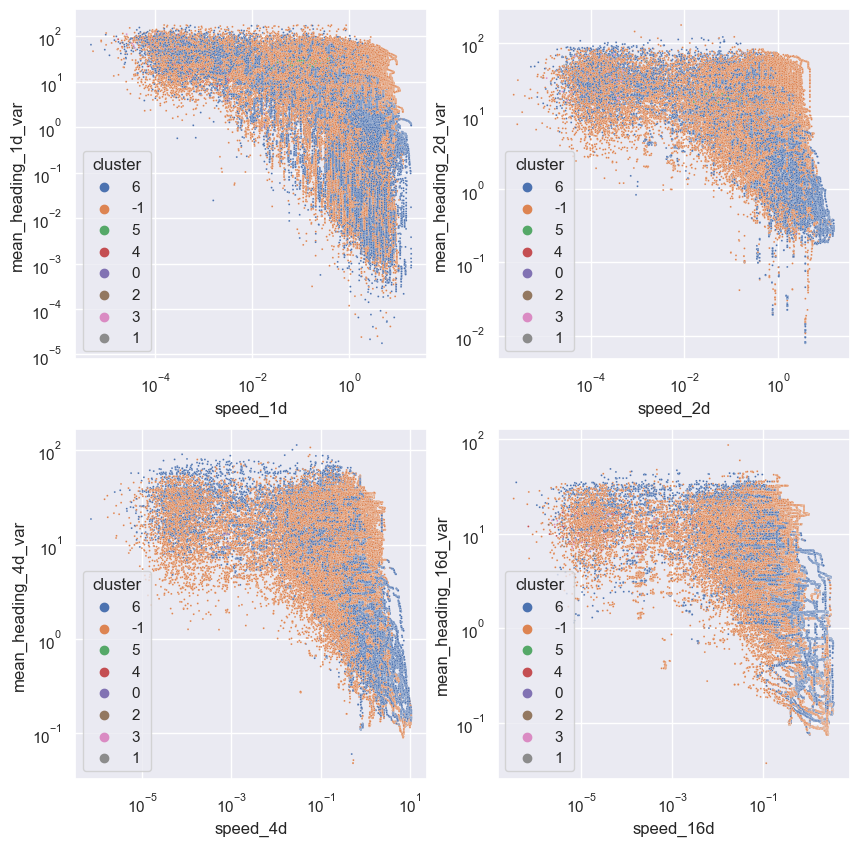

In [24]:
graph_data = tb_model #[tb_vulture["individual-local-identifier"] == 12]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(
    x="speed_1d",
    y="mean_heading_1d_var",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[0][0],
)
sns.scatterplot(
    x="speed_2d",
    y="mean_heading_2d_var",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[0][1],
)
sns.scatterplot(
    x="speed_4d",
    y="mean_heading_4d_var",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[1][0],
)
sns.scatterplot(
    x="speed_16d",
    y="mean_heading_16d_var",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[1][1],
)
ax[0][0].set_xscale("log")
ax[1][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[1][1].set_xscale("log")
ax[0][0].set_yscale("log")
ax[1][0].set_yscale("log")
ax[0][1].set_yscale("log")
ax[1][1].set_yscale("log")


<AxesSubplot: xlabel='location-lat', ylabel='location-long'>

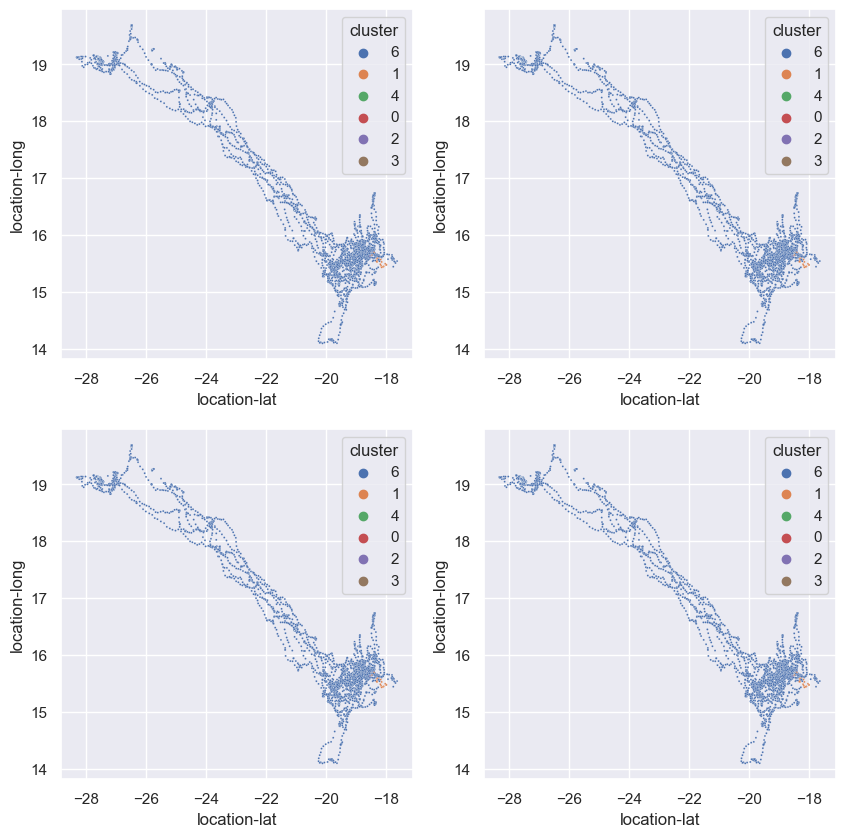

In [25]:
graph_data = tb_model[(tb_model["individual-local-identifier"] == 12) & (tb_model["cluster"] != "-1")]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[0][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[0][1],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[1][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[1][1],
)


<AxesSubplot: ylabel='$\\lambda$ value'>

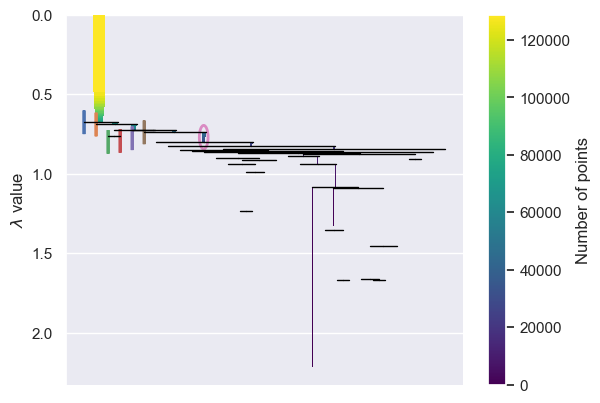

In [26]:
hdb_pipeline.steps[2][1].condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

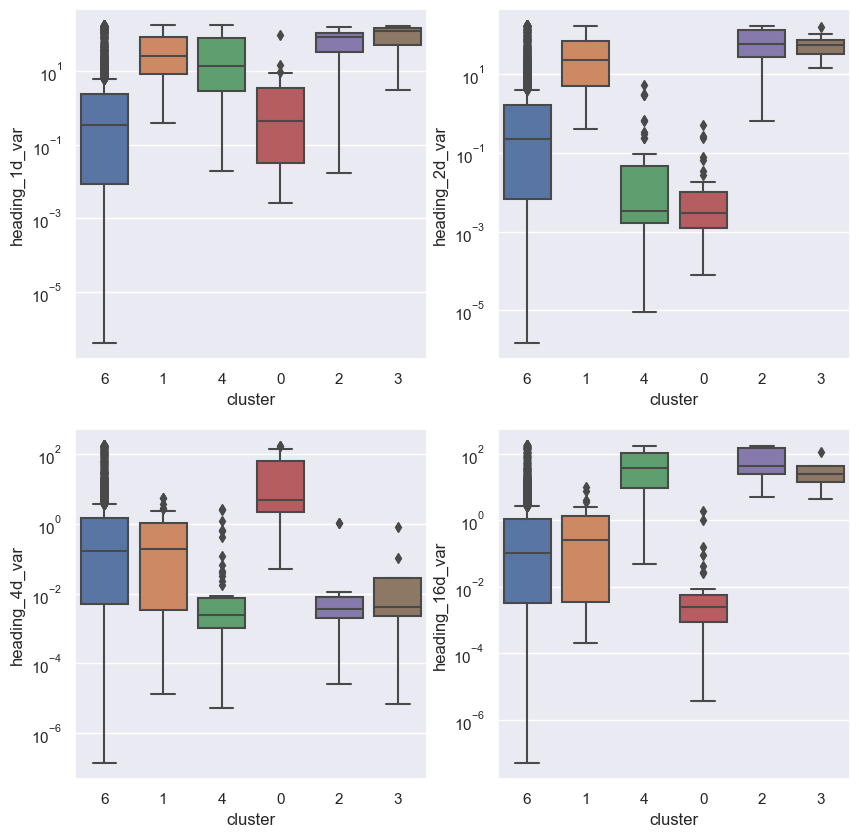

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(
    data = graph_data,
    x = "cluster",
    y = "heading_1d_var",
    ax = ax[0][0]
)
sns.boxplot(
    data = graph_data,
    x = "cluster",
    y = "heading_2d_var",
    ax = ax[0][1]
)
sns.boxplot(
    data = graph_data,
    x = "cluster",
    y = "heading_4d_var",
    ax = ax[1][0]
)
sns.boxplot(
    data = graph_data,
    x = "cluster",
    y = "heading_16d_var",
    ax = ax[1][1]
)
ax[0][0].set_yscale("log")
ax[1][0].set_yscale("log")
ax[0][1].set_yscale("log")
ax[1][1].set_yscale("log")


In [34]:
X = tb_model.groupby("individual-local-identifier")[model_vars].transform(lambda x: (x - x.mean())/x.std())
power = PowerTransformer()
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
hdb_pipeline = Pipeline([("power", power), ("hdb", hdb)])
tb_model["cluster"] = hdb_pipeline.fit_predict(X)
tb_model["cluster"] = tb_model["cluster"].astype(str)

In [33]:
tb_model["cluster"].value_counts()

1     72457
-1    56198
2        65
0        59
Name: cluster, dtype: int64

<AxesSubplot: xlabel='location-lat', ylabel='location-long'>

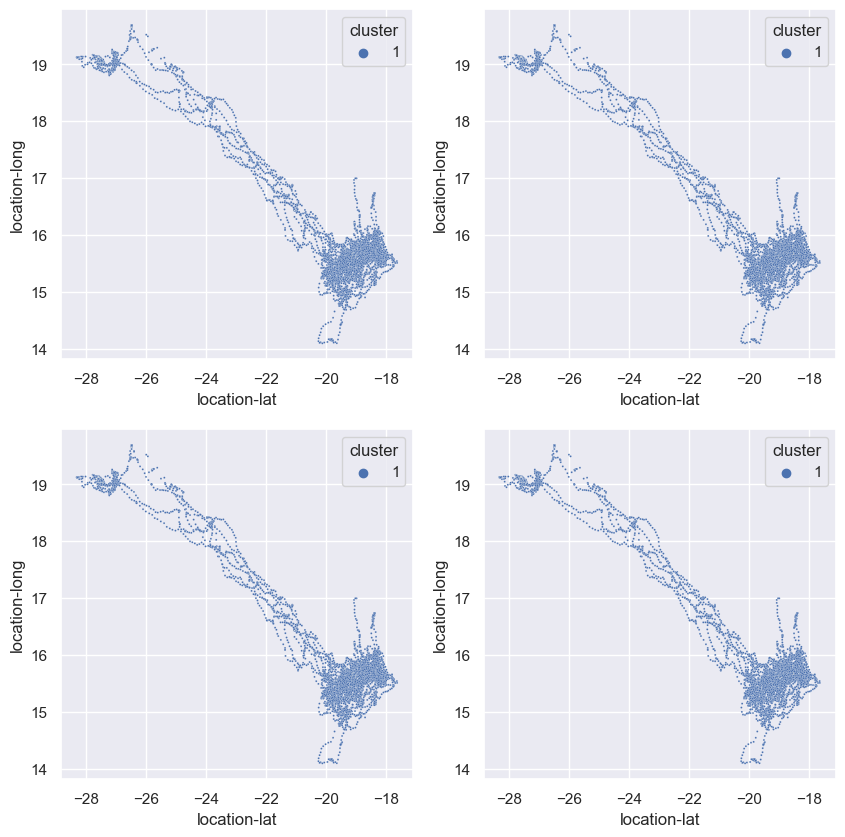

In [32]:
graph_data = tb_model[(tb_model["individual-local-identifier"] == 12) & (tb_model["cluster"] != "-1")]
time_mask = (graph_data["days_since_start"] < 2000) & (
    graph_data["days_since_start"] > 20
)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[0][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[0][1],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[1][0],
)
sns.scatterplot(
    x="location-lat",
    y="location-long",
    data=graph_data[time_mask],
    hue="cluster",
    s=2,
    ax=ax[1][1],
)
